# Anomaly Detection

## Install packages

In [66]:
! pip install pandas matplotlib seaborn ace_tools statsmodels scikit-learn imblearn xgboost

## Import Packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from xgboost import XGBClassifier
from scipy.stats import zscore
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

## Data Reading and processing

In [136]:
df = pd.read_csv('burke-gilman-trail-north-of-ne-70th-st-bike-and-ped-counter (4).csv')
df

,Date,BGT North of NE 70th Total,Ped South,Ped North,Bike North,Bike South
0,2014-01-01T00:00:00.000,15.0,0.0,2.0,2.0,11.0
1,2014-01-01T01:00:00.000,9.0,1.0,0.0,1.0,7.0
2,2014-01-01T02:00:00.000,9.0,0.0,0.0,0.0,9.0
3,2014-01-01T03:00:00.000,19.0,0.0,0.0,0.0,19.0
4,2014-01-01T04:00:00.000,19.0,0.0,0.0,0.0,19.0
...,...,...,...,...,...,...
52579,2019-12-31T19:00:00.000,6.0,2.0,1.0,1.0,2.0
52580,2019-12-31T20:00:00.000,2.0,0.0,0.0,0.0,2.0
52581,2019-12-31T21:00:00.000,3.0,1.0,2.0,0.0,0.0
52582,2019-12-31T22:00:00.000,1.0,0.0,0.0,0.0,1.0


<span style="color:green"> BGT North of NE 70th Total = Total number of pedestrians + bikers recorded at a location on the Burke-Gilman Trail (North of NE 70th Street) during that hour</span>  
<span style="color:green"> Ped North = Number of pedestrians going northbound during that hour</span>  
<span style="color:green"> Bike North = Number of bikes going northbound during that hour</span>  
<span style="color:green"> Ped South = Number of pedestrians going southbound during that hour</span>  
<span style="color:green"> Bike South = Number of bikes going southbound during that hour</span>


### Converting TimeStamp To Date-Time

In [137]:
df['anamoly'] = (df['BGT North of NE 70th Total'] >= 500).astype(int)

In [138]:
df['anamoly']

0        0
1        0
2        0
3        0
4        0
        ..
52579    0
52580    0
52581    0
52582    0
52583    0
Name: anamoly, Length: 52584, dtype: int64

In [139]:
print(df["anamoly"].value_counts())


anamoly
0    52088
1      496
Name: count, dtype: int64


In [140]:
df['Date'] = pd.to_datetime(df['Date'])

### Checking null values in columns

In [141]:
df.isnull().values.any()
df[df.isnull().values.any(axis=1)]
# df[df.isnull().values.sum()]

,Date,BGT North of NE 70th Total,Ped South,Ped North,Bike North,Bike South,anamoly
5337,2014-08-11 09:00:00,NaN,NaN,NaN,NaN,NaN,0
6586,2014-10-02 10:00:00,NaN,NaN,NaN,NaN,NaN,0
9563,2015-02-03 11:00:00,NaN,NaN,NaN,NaN,NaN,0
10346,2015-03-08 02:00:00,NaN,NaN,NaN,NaN,NaN,0
19250,2016-03-13 02:00:00,NaN,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...
41020,2018-09-06 04:00:00,NaN,NaN,NaN,NaN,NaN,0
41021,2018-09-06 05:00:00,NaN,NaN,NaN,NaN,NaN,0
41022,2018-09-06 06:00:00,NaN,NaN,NaN,NaN,NaN,0
41023,2018-09-06 07:00:00,NaN,NaN,NaN,NaN,NaN,0


In [142]:
columns = ['BGT North of NE 70th Total',	'Ped South',	'Ped North',	'Bike North',	'Bike South']

df[columns] = df[columns].astype(float)
# df = df.astype(float)

### Determining whether data is normally distributed, skewed

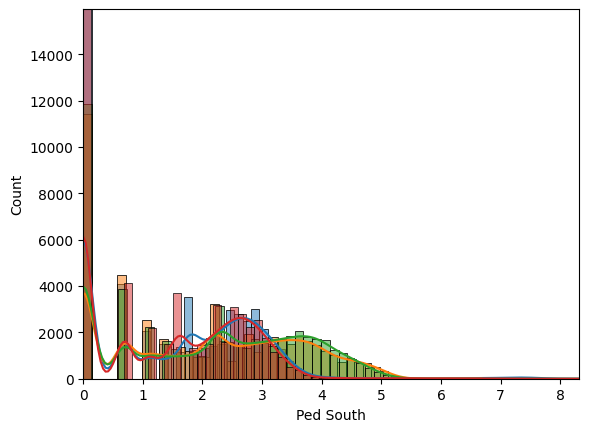

In [150]:

import numpy as np

# Checking for normality using histogram
sns.histplot(df['Ped South'], kde= True)
sns.histplot(df['Bike North'], kde= True)
sns.histplot(df['Bike South'], kde= True)
sns.histplot(df['Ped North'], kde= True)
plt.xlim(0, df["Ped North"].max())  # Use the actual max value instead of 1000
plt.ylim(0, df["Ped North"].value_counts().max())  # Set y-limit based on data distribution
plt.show()


We can observe that data is right skewed so we will be applying the log transformation to avoid the high skewness and median for the null values

In [146]:
# Apply log transformation to avoid high skewness
df["Ped South"] = np.log1p(df["Ped South"])
df["Ped North"] = np.log1p(df["Ped North"])
df["Bike South"] = np.log1p(df["Bike South"])
df["Bike North"] = np.log1p(df["Bike North"])


#Filling the na values with median since the data are skewed 
columns_to_fill = ['Ped South','Bike North','Bike South','Ped North']
total = 'BGT North of NE 70th Total'
df[columns_to_fill] = df[columns_to_fill].apply(lambda x:x.fillna(x.median()))

df[total] = df[columns_to_fill].sum(axis=1)

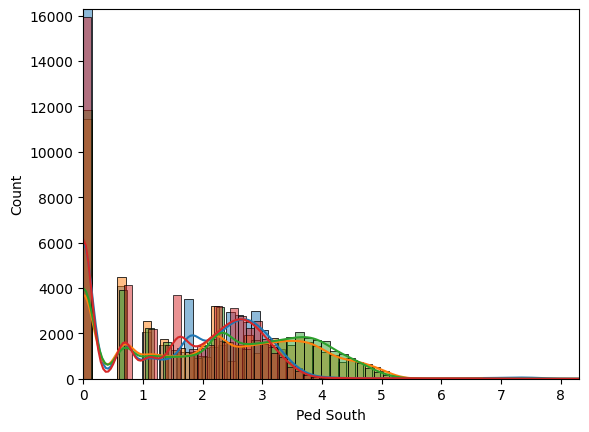

In [147]:


# Checking for normality using histogram
sns.histplot(df['Ped South'], kde= True)
sns.histplot(df['Bike North'], kde= True)
sns.histplot(df['Bike South'], kde= True)
sns.histplot(df['Ped North'], kde= True)
plt.xlim(0, df["Ped South"].max())  # Use the actual max value instead of 1000
plt.ylim(0, df["Ped South"].value_counts().max())  # Set y-limit based on data distribution
plt.show()


### Adding lag features and setting target columns

### Lag features are used in time series analysis or machine learning to represent past values of a variable.
##### Let us suppose a dataset having features Day and Sales
| Day | Sales |
|-----|-------|
| 1   | 100   |
| 2   | 120   |
| 3   | 130   |
| 4   | 110   |

##### Now if we apply lag freature to analyse the past 1 day values then we will using lag 1 feature which will shift our values to past 1 and the above dataset looks like this
| Day | Sales | Sales_lag1 |
|-----|-------|------------|
| 1   | 100   | NaN        |
| 2   | 120   | 100        |
| 3   | 130   | 120        |
| 4   | 110   | 130        |

##### So here if we have to analyse the future data in the present then we will use lag -3 which ill shift our values to future 3 for example in day 1 it will take the value of day 3 and in day 2 it will take the value of day 4 the value of the first dataset looks like this if we apply this feature
| Day | Sales | Sales_lag1 |
|-----|-------|------------|
| 1   | 100   | NaN        |
| 2   | 120   | 100        |
| 3   | 130   | 120        |
| 4   | 110   | 130        |





In [104]:
log_threshold = np.log1p(500) 

In [115]:
df.isnull().values.any()
df = df.sort_values('Date')
df['anamoly'] = (df['BGT North of NE 70th Total'] >= 500).astype(int)
df['lag_1hr'] = df['BGT North of NE 70th Total'].shift(1)
df['lag_2hr'] = df['BGT North of NE 70th Total'].shift(2)
df['lag_3hr'] = df['BGT North of NE 70th Total'].shift(3)
df['lag_(neg)3hr'] = df['BGT North of NE 70th Total'].shift(-3)

# negative lag feature .....
df['target_3hr'] = (df['BGT North of NE 70th Total'].shift(-3) >= 500).astype(int)

df.dropna(inplace=True)

df


,Date,BGT North of NE 70th Total,Ped South,Ped North,Bike North,Bike South,anamoly,lag_1hr,lag_2hr,lag_3hr,lag_(neg)3hr,target_3hr
3,2014-01-01 03:00:00,19.0,0.0,0.0,0.0,19.0,0,9.0,9.0,15.0,10.0,0
4,2014-01-01 04:00:00,19.0,0.0,0.0,0.0,19.0,0,19.0,9.0,9.0,10.0,0
5,2014-01-01 05:00:00,14.0,0.0,0.0,0.0,14.0,0,19.0,19.0,9.0,27.0,0
6,2014-01-01 06:00:00,10.0,0.0,1.0,1.0,8.0,0,14.0,19.0,19.0,29.0,0
7,2014-01-01 07:00:00,10.0,2.0,3.0,4.0,1.0,0,10.0,14.0,19.0,70.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
52576,2019-12-31 16:00:00,40.0,10.0,11.0,7.0,12.0,0,42.0,47.0,39.0,6.0,0
52577,2019-12-31 17:00:00,14.0,1.0,3.0,1.0,9.0,0,40.0,42.0,47.0,2.0,0
52578,2019-12-31 18:00:00,14.0,4.0,6.0,0.0,4.0,0,14.0,40.0,42.0,3.0,0
52579,2019-12-31 19:00:00,6.0,2.0,1.0,1.0,2.0,0,14.0,14.0,40.0,1.0,0


In [116]:
print(df["anamoly"].value_counts())

anamoly
0    52082
1      496
Name: count, dtype: int64


In [117]:
#Filling the na values with median since the data are skewed 
columns_to_fill = ['lag_1hr','lag_2hr','lag_3hr','lag_(neg)3hr']
df[columns_to_fill] = df[columns_to_fill].apply(lambda x:x.fillna(x.median()))

In [77]:
# df_normalized = df.copy()
# columns_to_normalize = ['Ped South','Bike North','Bike South','Ped North','BGT North of NE 70th Total']
# df_normalized[columns_to_normalize] = df[columns_to_normalize].apply(lambda x:(x-x.min())/(x.max()-x.min()))


In [78]:
# df_normalized

## Prepare Time-Based Data 

In [118]:
df['Weekdays'] = df['Date'].dt.dayofweek
df['Weekday Name'] = df['Date'].dt.day_name()
df['Day hours'] = df['Date'].dt.hour
df.head(20)

,Date,BGT North of NE 70th Total,Ped South,Ped North,Bike North,Bike South,anamoly,lag_1hr,lag_2hr,lag_3hr,lag_(neg)3hr,target_3hr,Weekdays,Weekday Name,Day hours
3,2014-01-01 03:00:00,19.0,0.0,0.0,0.0,19.0,0,9.0,9.0,15.0,10.0,0,2,Wednesday,3
4,2014-01-01 04:00:00,19.0,0.0,0.0,0.0,19.0,0,19.0,9.0,9.0,10.0,0,2,Wednesday,4
5,2014-01-01 05:00:00,14.0,0.0,0.0,0.0,14.0,0,19.0,19.0,9.0,27.0,0,2,Wednesday,5
6,2014-01-01 06:00:00,10.0,0.0,1.0,1.0,8.0,0,14.0,19.0,19.0,29.0,0,2,Wednesday,6
7,2014-01-01 07:00:00,10.0,2.0,3.0,4.0,1.0,0,10.0,14.0,19.0,70.0,0,2,Wednesday,7
8,2014-01-01 08:00:00,27.0,12.0,6.0,8.0,1.0,0,10.0,10.0,14.0,107.0,0,2,Wednesday,8
9,2014-01-01 09:00:00,29.0,5.0,14.0,8.0,2.0,0,27.0,10.0,10.0,126.0,0,2,Wednesday,9
10,2014-01-01 10:00:00,70.0,14.0,16.0,40.0,0.0,0,29.0,27.0,10.0,102.0,0,2,Wednesday,10
11,2014-01-01 11:00:00,107.0,20.0,39.0,47.0,1.0,0,70.0,29.0,27.0,115.0,0,2,Wednesday,11
12,2014-01-01 12:00:00,126.0,36.0,31.0,59.0,0.0,0,107.0,70.0,29.0,100.0,0,2,Wednesday,12


C:\Users\lenovo\AppData\Local\Temp\ipykernel_31364\1738686730.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=weekly_traffic.index, y=weekly_traffic.values, palette="Blues")


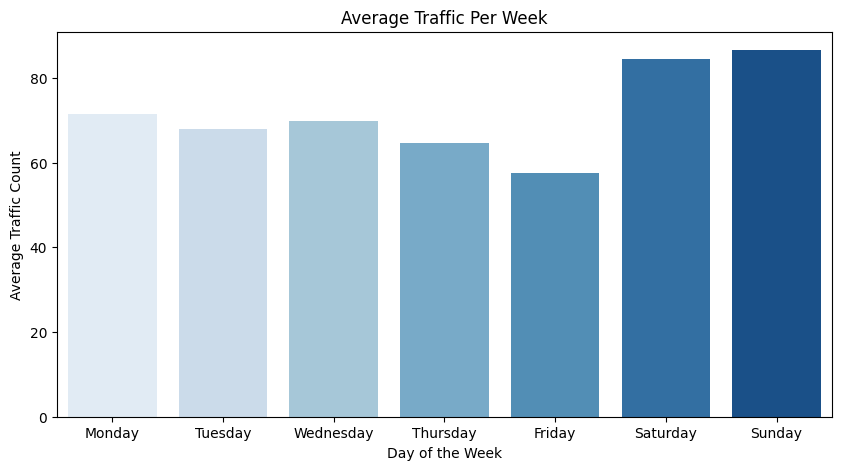

In [119]:
# Group by weekday and compute the mean
weekly_traffic = df.groupby('Weekday Name')['BGT North of NE 70th Total'].mean()

# Reorder to show Monday-Sunday in order
weekly_traffic = weekly_traffic.reindex(["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])


# Plot the results
plt.figure(figsize=(10, 5))
sns.barplot(x=weekly_traffic.index, y=weekly_traffic.values, palette="Blues")
plt.xlabel("Day of the Week")
plt.ylabel("Average Traffic Count")
plt.title("Average Traffic Per Week")
plt.show()

In [120]:
df['Date_new'] = pd.to_datetime(df['Date']) 
df.set_index('Date_new', inplace = True)


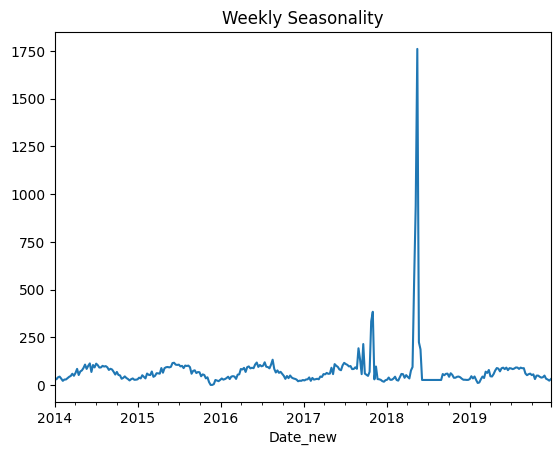

In [121]:
df["BGT North of NE 70th Total"].resample("7D").mean().plot(title="Weekly Seasonality")
plt.show()

### y axis total weekly season analysis


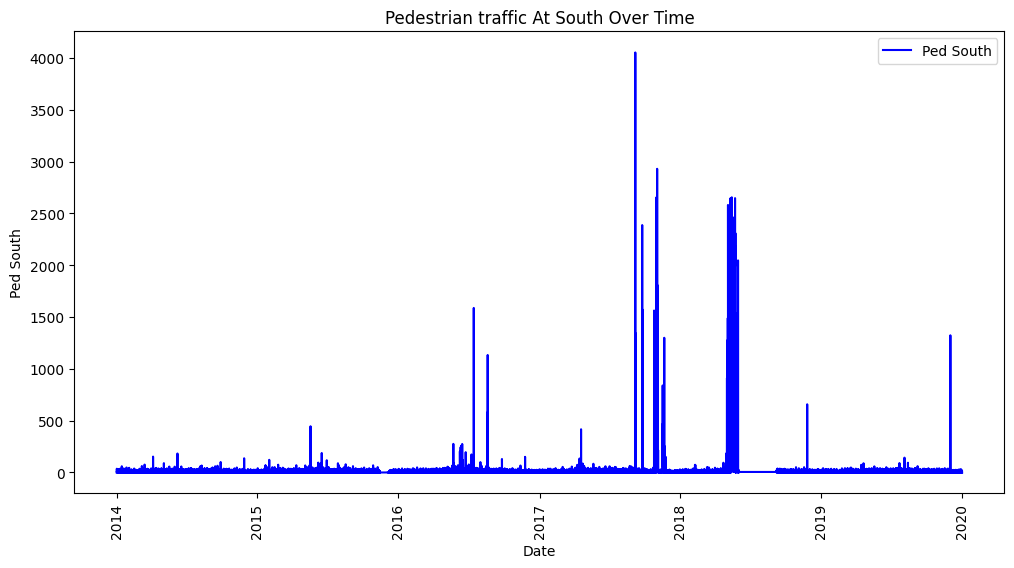

In [122]:

plt.figure(figsize=(12,6))
plt.plot(df.index, df['Ped South'],label = 'Ped South', color = 'Blue')
plt.title('Pedestrian traffic At South Over Time')
plt.xlabel('Date')
plt.ylabel('Ped South')
plt.legend()
plt.xticks(rotation=90)
plt.show()

## Applying Rolling Index

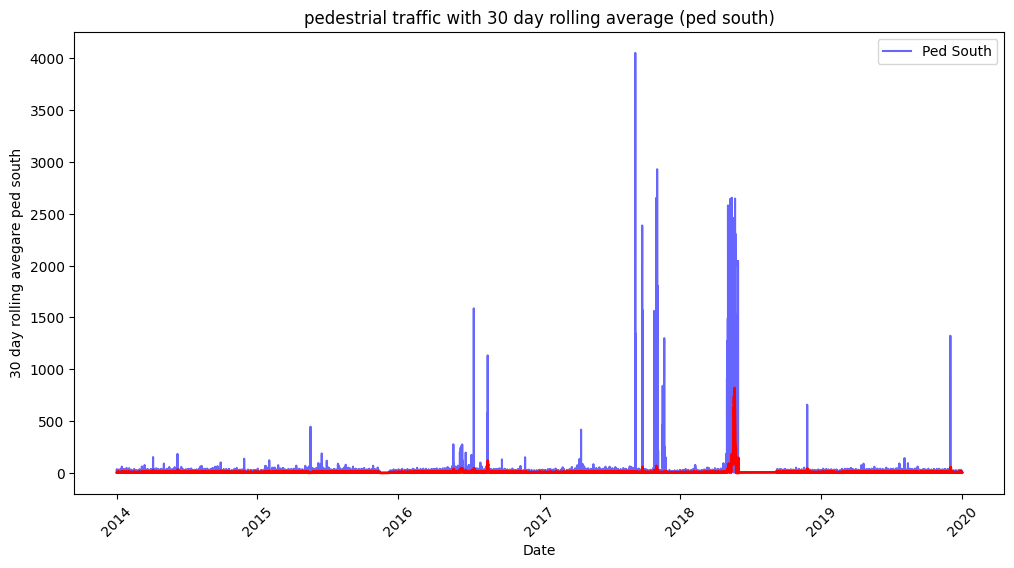

In [123]:
df['Ped South Rolling Average'] = df['Ped South'].rolling(window = 30).mean()
df['Bike South Rolling Average'] = df['Bike South'].rolling(window = 30).mean()
df['Ped North Rolling Average'] = df['Ped North'].rolling(window = 30).mean()
df['Bike North Rolling Average'] = df['Bike North'].rolling(window = 30).mean()
plt.figure(figsize= (12,6))
plt.plot(df.index, df['Ped South'], label = 'Ped South', color = 'Blue',alpha = 0.6)
plt.plot(df.index, df['Ped North Rolling Average'], color = 'red',linewidth= 2)
plt.title('pedestrial traffic with 30 day rolling average (ped south)')
plt.xlabel('Date')
plt.ylabel('30 day rolling avegare ped south')
plt.legend()
plt.xticks(rotation = 45)
plt.show()

 ## Decomposition of time series data

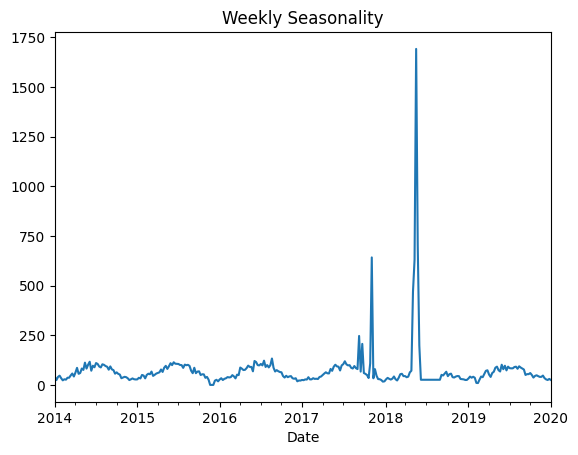

In [124]:

# df['Date'] = pd.to_datetime(df['Date'])
df.set_index("Date", inplace=True)
df["BGT North of NE 70th Total"].resample("W").mean().plot(title="Weekly Seasonality")
plt.show()


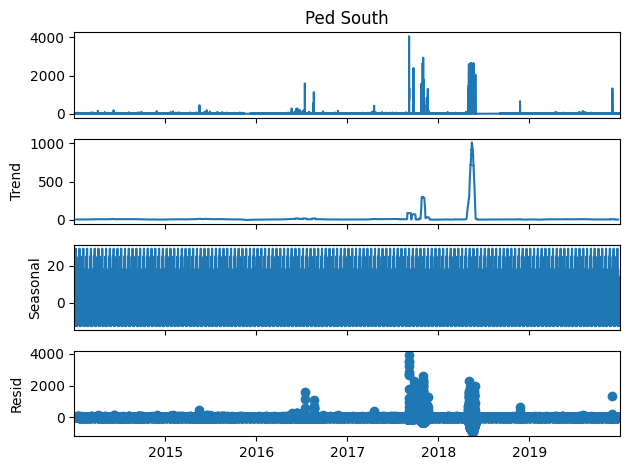

In [125]:
result = seasonal_decompose(df['Ped South'],model='addictive', period = 365)
result.plot()
plt.show()

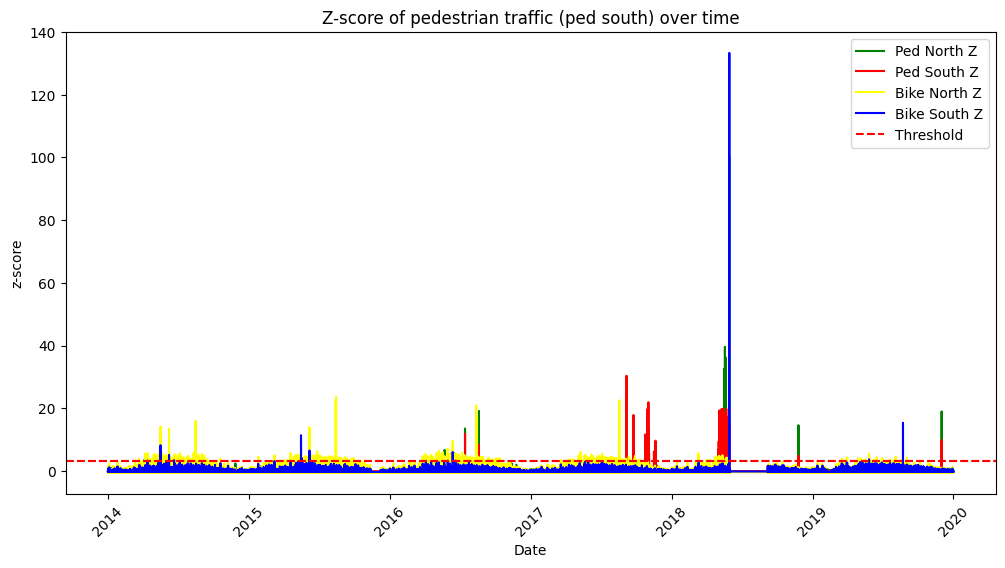

                     BGT North of NE 70th Total  Ped South  Ped North  \
Date                                                                    
2016-05-22 11:00:00                       628.0      164.0      242.0   
2016-05-22 12:00:00                       774.0      276.0      282.0   
2016-06-08 11:00:00                       525.0      204.0      234.0   
2016-06-11 11:00:00                       682.0      258.0      235.0   
2016-06-14 11:00:00                       560.0      275.0      246.0   
...                                         ...        ...        ...   
2018-05-30 04:00:00                     10493.0     2047.0      255.0   
2018-11-25 09:00:00                      1278.0      658.0      603.0   
2018-11-25 10:00:00                       314.0       35.0      254.0   
2019-12-01 08:00:00                      1764.0     1324.0      428.0   
2019-12-01 09:00:00                      1009.0      217.0      782.0   

                     Bike North  Bike South  anamo

In [126]:
df[['Ped North Z', 'Ped South Z', 'Bike North Z', 'Bike South Z']] = df[['Ped North', 'Ped South', 'Bike North', 'Bike South']].apply(zscore)
plt.figure(figsize=(12,6))
plt.plot(df.index, df['Ped North Z'],label = 'Ped North Z', color = 'green')
plt.plot(df.index, df['Ped South Z'],label = 'Ped South Z', color = 'red')
plt.plot(df.index, df['Bike North Z'],label = 'Bike North Z', color = 'yellow')
plt.plot(df.index, df['Bike South Z'],label = 'Bike South Z', color = 'blue')
plt.axhline(y= 3, color = 'red', linestyle = '--', label = 'Threshold')
plt.axhline(y=3, color = 'red', linestyle = '--')
plt.title('Z-score of pedestrian traffic (ped south) over time')
plt.xlabel('Date')
plt.ylabel('z-score')
plt.legend()
plt.xticks(rotation = 45)
plt.show()

anomalies = df[df['Ped North Z'].abs()>5]
print(anomalies)

# Extracting Time Features

In [127]:
df = df.drop('Weekday Name',axis = 'columns')

In [ ]:
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE

# Separate features and target
X = df.drop("target_3hr", axis=1)
y = df["target_3hr"]

# Impute missing values with the mean (or use "median", "most_frequent", etc.)
imputer = SimpleImputer(strategy="mean")
X_imputed = imputer.fit_transform(X)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_imputed, y)

# Combine back into DataFrame
resampled_df = pd.concat([
    pd.DataFrame(X_resampled, columns=X.columns),
    pd.Series(y_resampled, name="target_3hr")
], axis=1)


ValueError: Input X contains NaN.
SMOTE does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [129]:
# Step 1: Separate majority and minority classes
majority_class = df[df["target_3hr"] == 0]
minority_class = df[df["target_3hr"] == 1]

# Step 2: Sample only if population is large enough
n_samples = min(len(majority_class), len(minority_class))
majority_class_sampled = majority_class.sample(n=n_samples, random_state=42)
minority_class_sampled = minority_class.sample(n=n_samples, random_state=42)

# Step 3: Combine both
balanced_df = pd.concat([majority_class_sampled, minority_class_sampled])

# Step 4: Shuffle
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)


In [89]:
df

,BGT North of NE 70th Total,Ped South,Ped North,Bike North,Bike South,anamoly,lag_1hr,lag_2hr,lag_3hr,lag_(neg)3hr,...,Weekdays,Day hours,Ped South Rolling Average,Bike South Rolling Average,Ped North Rolling Average,Bike North Rolling Average,Ped North Z,Ped South Z,Bike North Z,Bike South Z
Date,,,,,,,,,,,,,,,,,,,,,
2014-01-01 03:00:00,2.995732,0.000000,0.000000,0.000000,2.995732,0,2.302585,3.465736,4.682131,3.583519,...,2,3,NaN,NaN,NaN,NaN,-1.226005,-1.169020,-1.358820,0.569019
2014-01-01 04:00:00,2.995732,0.000000,0.000000,0.000000,2.995732,0,2.995732,2.302585,3.465736,4.787492,...,2,4,NaN,NaN,NaN,NaN,-1.226005,-1.169020,-1.358820,0.569019
2014-01-01 05:00:00,2.708050,0.000000,0.000000,0.000000,2.708050,0,2.995732,2.995732,2.302585,7.401231,...,2,5,NaN,NaN,NaN,NaN,-1.226005,-1.169020,-1.358820,0.382470
2014-01-01 06:00:00,3.583519,0.000000,0.693147,0.693147,2.197225,0,2.708050,2.995732,2.995732,7.795647,...,2,6,NaN,NaN,NaN,NaN,-0.668103,-1.169020,-0.908394,0.051223
2014-01-01 07:00:00,4.787492,1.098612,1.386294,1.609438,0.693147,0,3.583519,2.708050,2.995732,9.254836,...,2,7,NaN,NaN,NaN,NaN,-0.110200,-0.354980,-0.312964,-0.924103
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-31 16:00:00,9.527193,2.397895,2.484907,2.079442,2.564949,1,9.382612,10.006766,9.406565,3.583519,...,1,16,1.544176,1.715730,1.521509,1.564363,0.774055,0.607751,-0.007543,0.289676
2019-12-31 17:00:00,5.075174,0.693147,1.386294,0.693147,2.302585,0,9.527193,9.382612,10.006766,1.098612,...,1,17,1.513633,1.704514,1.490966,1.491122,-0.110200,-0.655418,-0.908394,0.119544
2019-12-31 18:00:00,5.164786,1.609438,1.945910,0.000000,1.609438,0,5.075174,9.527193,9.382612,1.791759,...,1,18,1.494040,1.655127,1.502182,1.414369,0.340226,0.023527,-1.358820,-0.329930


In [132]:
# features =  ['lag_1hr',	'lag_2hr','lag_3hr']
# Step 3: Split into Features and Target
X = balanced_df.drop("target_3hr", axis=1)
y = balanced_df["target_3hr"]

#split the dataset into training and test dataset

X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.3, random_state = 42) 
model = RandomForestClassifier(class_weight='balanced',n_estimators=50,random_state= 42)
# model = XGBClassifier(scale_pos_weight=100, use_label_encoder=False, eval_metric="logloss")

model.fit(X_train,Y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
from sklearn.metrics import precision_recall_curve

# Get prediction probabilities
y_probs = model.predict_proba(X_test)[:, 1]  # Get probability of class 1

# Adjust threshold to increase recall
threshold = 0.3  # Lower threshold to catch more anomalies
y_pred_adjusted = (y_probs >= threshold).astype(int)

accuracy = accuracy_score(Y_test, y_pred_adjusted)
print(f"Model Accuracy: {accuracy:.2f}")
print(classification_report(Y_test, y_pred))

Model Accuracy: 0.99
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       150
           1       0.99      1.00      0.99       148

    accuracy                           0.99       298
   macro avg       0.99      0.99      0.99       298
weighted avg       0.99      0.99      0.99       298



In [133]:
import joblib
joblib.dump(model,"random_forest.pkl")

['random_forest.pkl']

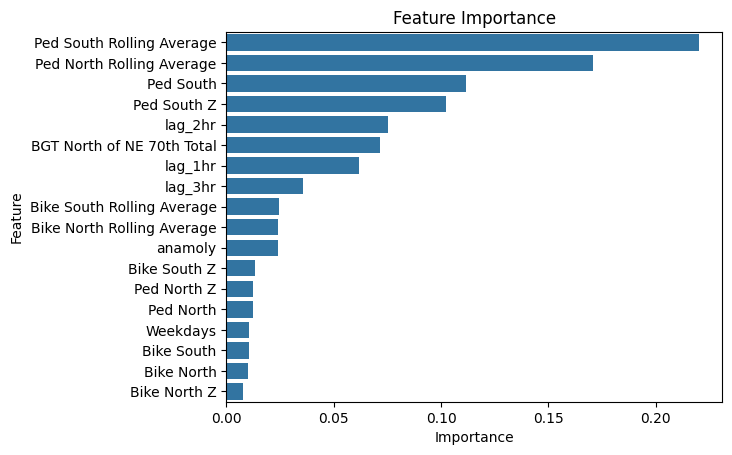

In [ ]:

# Get feature importances
importances = model.feature_importances_

# Create a DataFrame for visualization
feature_importance_df = pd.DataFrame({"Feature": X.columns, "Importance": importances})
feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False)

# Plot feature importances
sns.barplot(x="Importance", y="Feature", data=feature_importance_df)
plt.title("Feature Importance")
plt.show()

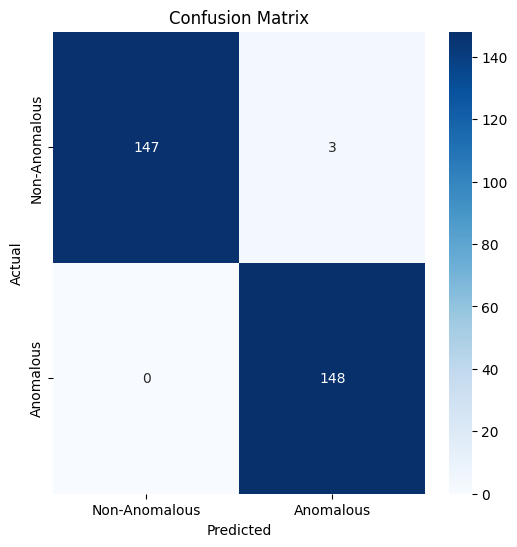

In [134]:
# Calculate the confusion matrix
cm = confusion_matrix(Y_test, y_pred_adjusted)

# Plot the confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Anomalous', 'Anomalous'], yticklabels=['Non-Anomalous', 'Anomalous'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

#### remaining features (rolling mean 3h, rolling std 3h,rolling 7d avg,month)

In [ ]:
# from typing import Union
# from fastapi import FastAPI

# app = FastAPI()

# # @app.get("/")
# def root():
#     print("hello this is inferenece model")

# @app.get("/data")
# def get_data():
    

